In [1]:
# Import lots of stuff

import logging
import threading
import json 
import itertools
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import ibm_db
import shap

from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance

from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions.db import Database
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType  
from iotfunctions.enginelog import EngineLogging
from iotfunctions.dbtables import FileModelStore
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from iotfunctions.dbtables import FileModelStore, DBModelStore
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore, SimpleRegressor)
from iotfunctions.anomaly import GBMRegressor
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import MinCovDet
from sklearn import metrics
import scipy as sp
import scipy.fftpack
#import skimage as ski  
#from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

2023-01-09 19:11:21.949511: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-09 19:11:22.079898: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-09 19:11:22.079915: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-09 19:11:22.104696: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-09 19:11:22.579204: W tensorflow/stream_executor/platform/de

In [2]:
# Set up Monitor pipeline related infrastructure
db_schema=None
class DatabaseDummy:
    tenant_id = '###_IBM_###'
    db_type = 'db2'
    model_store = FileModelStore('./')
    def _init(self):
        return

db = DatabaseDummy()
        
print (db.tenant_id)

2023-01-09T19:11:23.180 INFO iotfunctions.dbtables.__init__ Init FileModelStore with path: ./
###_IBM_###


### Loading and preparing data


In [3]:
df_input_raw = pd.read_csv('./data/ExampleFanBearingTemperatureDERegression.csv.bz2', compression='bz2',
                           parse_dates=['RCV_TIMESTAMP_UTC']) #, index_col=False, parse_dates=['DATETIME'], comment='#')

In [4]:
df_input_raw.columns

Index(['EVENTTIME_UNIXTIME', 'EVENTTIME_STRING_UTC', 'VALUE', 'STATUS',
       'DEVICETYPE', 'DEVICEID', 'LOGICALINTERFACE_ID', 'EVENTTYPE', 'FORMAT',
       'RCV_TIMESTAMP_UTC', 'UPDATED_UTC'],
      dtype='object')

In [5]:
# drop stuff we don't need
df_input = df_input_raw.drop(columns=['EVENTTIME_STRING_UTC','STATUS','DEVICETYPE','LOGICALINTERFACE_ID','EVENTTYPE',
                                     'FORMAT','UPDATED_UTC'])

In [6]:
# data base collects data from multiple sensors
df_input['DEVICEID'].unique()

array(['BKB-1EC4F68B5DAD4AC4B011627182D8E368',
       'BKB-31ECCCEC726744898554A981A0D7D901',
       'BKB-56D51F621558447A80A58A8CF875654C',
       'BKB-7386107D608B45D7A1AAF3EE6C280919',
       'BKB-62F49FF0F63F46C99A5610E5A09B95E6',
       'BKB-9CB76C671FCE4A33B5542CDE7FC79BF9',
       'BKB-BCC667058C084D32983E5934FB787A3D',
       'BKB-E966B4307D274777B4000A3E11BC0373'], dtype=object)

In [7]:
df_input.head(3)

,EVENTTIME_UNIXTIME,VALUE,DEVICEID,RCV_TIMESTAMP_UTC
0,1609459200,145.6699,BKB-1EC4F68B5DAD4AC4B011627182D8E368,2022-02-11-19.41.15.000000
1,1609459260,145.6699,BKB-1EC4F68B5DAD4AC4B011627182D8E368,2022-02-11-19.41.15.000000
2,1609459320,145.6699,BKB-1EC4F68B5DAD4AC4B011627182D8E368,2022-02-11-19.41.15.000000


### How does it relate to Monitor Pipeline 2.0 ?


With pipeline 2.0 individual sensors are treated as independent data contributors to be grouped and assembled to multivariate data according to asset hierarchy.

This is reflected in the database, resp. CSV layout shown below: The deviceID refers to a single sensor, sensor data readings are features and targets of the asset model.

### Digression Pipeline 2.0

<img src='./images/Monitor8.10StreamingAnalyticswithKafkaWFv03a_1.png' height="80%" width="80%"/>

<img src='./images/Monitor8.10StreamingAnalyticswithKafkaWFv03a_2.png' height="99%" width="99%"/>

<img src='./images/Monitor8.10StreamingAnalyticswithKafkaWFv03a_4.png' height="80%" width="80%"/>

<img src='./images/Monitor8.10StreamingAnalyticswithKafkaWFv03a_6.png' height="80%" width="80%"/>

### Turning multiple univariate data streams into a single multivariate data stream

Pipeline 2.0 offers the `Reidentify` catalog function to rename the 'Value' column for each sensor to a name related to this sensor. The ONNX model executor catalog function then takes data from multiple "re-identified" data sources.

Pandas pivot_table is roughly equivalent

Example (univariate without Reidentify):

<img src="./images/ONNX_example.png" height="50%" width="50%" />

In [8]:
# Pivot table
df_i = df_input.pivot_table(index='EVENTTIME_UNIXTIME', columns=['DEVICEID'], values='VALUE')

In [9]:
df_i.head(2)

DEVICEID,BKB-1EC4F68B5DAD4AC4B011627182D8E368,BKB-31ECCCEC726744898554A981A0D7D901,BKB-56D51F621558447A80A58A8CF875654C,BKB-62F49FF0F63F46C99A5610E5A09B95E6,BKB-7386107D608B45D7A1AAF3EE6C280919,BKB-9CB76C671FCE4A33B5542CDE7FC79BF9,BKB-BCC667058C084D32983E5934FB787A3D,BKB-E966B4307D274777B4000A3E11BC0373
EVENTTIME_UNIXTIME,,,,,,,,
1609459200,145.6699,435.9766,302.8477,34.57910,400.5117,79.86523,73.31445,1354.125
1609459260,145.6699,435.9961,302.8945,35.35498,400.4727,80.26855,74.82324,1380.422


In [10]:
# make it palatable to pipeline 1.0
df_i['entity'] = 'myentity'
df_j = df_i.reset_index().set_index(['entity','EVENTTIME_UNIXTIME'])

In [11]:
features = df_input['DEVICEID'].unique().tolist()

targets = ['BKB-1EC4F68B5DAD4AC4B011627182D8E368']
predictions = ['BKB-1EC4F68B5DAD4AC4B011627182D8E368_pred']
features.remove(targets[0])

### Features, Targets ?



```
['BKB-31ECCCEC726744898554A981A0D7D901',  # Flue Gas Outlet Pressure
 'BKB-56D51F621558447A80A58A8CF875654C',  # Flue Gas Inlet Temp
 'BKB-7386107D608B45D7A1AAF3EE6C280919',  # Flue Gas Inlet Pressure
 'BKB-62F49FF0F63F46C99A5610E5A09B95E6',  # Pressure Rise
 'BKB-9CB76C671FCE4A33B5542CDE7FC79BF9',  # Ambient Air Temp
 'BKB-BCC667058C084D32983E5934FB787A3D',  # Control Valve (Vane or Damper) Position
 'BKB-E966B4307D274777B4000A3E11BC0373']  # Flue Gas Inlet Flow
```

target
``` 
['BKB-1EC4F68B5DAD4AC4B011627182D8E368']  # Temperature of Surface
```

Goal is to predict the surface temperature from the features and to raise an alert if prediction and actual deviate.

In [12]:
features, targets

(['BKB-31ECCCEC726744898554A981A0D7D901',
  'BKB-56D51F621558447A80A58A8CF875654C',
  'BKB-7386107D608B45D7A1AAF3EE6C280919',
  'BKB-62F49FF0F63F46C99A5610E5A09B95E6',
  'BKB-9CB76C671FCE4A33B5542CDE7FC79BF9',
  'BKB-BCC667058C084D32983E5934FB787A3D',
  'BKB-E966B4307D274777B4000A3E11BC0373'],
 ['BKB-1EC4F68B5DAD4AC4B011627182D8E368'])

### Invoking Pipeline 1.0 function to generate an ONNX model for pipeline 2.0

#### Train in python, run in Java

GBMRegressor implements a mini training pipeline

- it checks whether feature and target data are highly correlated (and aborts training if they are)
- it splits data into training and test data to perform validation.
- it applies randomized search over a set of hyperparms to find the best performing trained model according to a predefined metric (usually R2)
- this best performing model is stored in a database (or file)

In [13]:
# set up mini Monitor pipeline
# debugging
EngineLogging.configure_console_logging(logging.DEBUG)

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

# pass features, targets and the name(s) for predicted targets

# GBM Regressor implements a mini data
# use a gradient booster with default hyperparameters:
#    500 trees, 40 leaves, learning rate 0.2, 
test = GBMRegressor(features, targets, predictions)


et = test._build_entity_type(columns = [Column('doesnotmatter',Float())], **jobsettings)
test._entity_type = et
test.auto_train = True
test.delete_existing_models = True
#dfs[0] = test.execute(df=dfs[0])

EngineLogging.configure_console_logging(logging.INFO)

2023-01-09T19:12:47.550 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2023-01-09T19:12:47.551 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2023-01-09T19:12:47.552 DEBUG iotfunctions.util.__init__ Starting trace
2023-01-09T19:12:47.553 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_GBMRegressor_20230109181247
2023-01-09T19:12:47.553 DEBUG iotfunctions.util.__init__ auto_save None
2023-01-09T19:12:47.554 DEBUG iotfunctions.util.categorize_args categorizing arguments
2023-01-09T19:12:47.555 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2023-01-09T19:12:47.555 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_GBMREGRESSOR
Functions:
Granularities:
No schedules metadata


In [14]:
df_j = test.execute(df=df_j)

2023-01-09T19:12:49.028 ERROR iotfunctions.base.get_bucket_name Could not find credentials for entity type. COS read/write is disabled 
2023-01-09T19:12:49.029 INFO iotfunctions.base.delete_models Model names to delete: ['model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.923b4cfa4b2ecac0a4b6b4ea63791f8e5de3b2c744534d152ee01c2f55026109:BKB-1EC4F68B5DAD4AC4B011627182D8E368.myentity']
2023-01-09T19:12:49.030 INFO iotfunctions.dbtables.delete_model Model model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.923b4cfa4b2ecac0a4b6b4ea63791f8e5de3b2c744534d152ee01c2f55026109:BKB-1EC4F68B5DAD4AC4B011627182D8E368.myentity has been deleted from filesystem
2023-01-09T19:12:49.030 INFO iotfunctions.base.get_models_for_training predicting target BKB-1EC4F68B5DAD4AC4B011627182D8E368
2023-01-09T19:12:49.031 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.923b4cfa4b2ecac0a4b6b4ea63791f8e5de3b2c744534d152ee01c2f55026109:BKB-1EC4F68B5DAD4AC4B011627182D8E368.myentit

#### Check

Model with filename
`../KPI_MODEL_STOREmodel.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.923b4cfa4b2ecac0a4b6b4ea63791f8e5de3b2c744534d152ee01c2f55026109:BKB-1EC4F68B5DAD4AC4B011627182D8E368.myentity`

now exist in my local filesystem.

In [15]:
# introspect the model we retrieved from disk
modelName = 'model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.923b4cfa4b2ecac0a4b6b4ea63791f8e5de3b2c744534d152ee01c2f55026109:BKB-1EC4F68B5DAD4AC4B011627182D8E368.myentity'

meta = test.active_models[modelName][0]


In [16]:
meta.name, meta.features, meta.target, meta.estimator

('model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.923b4cfa4b2ecac0a4b6b4ea63791f8e5de3b2c744534d152ee01c2f55026109:BKB-1EC4F68B5DAD4AC4B011627182D8E368.myentity',
 ['BKB-31ECCCEC726744898554A981A0D7D901',
  'BKB-56D51F621558447A80A58A8CF875654C',
  'BKB-7386107D608B45D7A1AAF3EE6C280919',
  'BKB-62F49FF0F63F46C99A5610E5A09B95E6',
  'BKB-9CB76C671FCE4A33B5542CDE7FC79BF9',
  'BKB-BCC667058C084D32983E5934FB787A3D',
  'BKB-E966B4307D274777B4000A3E11BC0373'],
 'BKB-1EC4F68B5DAD4AC4B011627182D8E368',
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('gbm',
                  LGBMRegressor(learning_rate=0.2, n_estimators=500,
                                num_leaves=40, verbosity=-1))]))

In [17]:
print(meta.estimator)

Pipeline(steps=[('scaler', StandardScaler()),
                ('gbm',
                 LGBMRegressor(learning_rate=0.2, n_estimators=500,
                               num_leaves=40, verbosity=-1))])


In [18]:
modelName = 'model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.923b4cfa4b2ecac0a4b6b4ea63791f8e5de3b2c744534d152ee01c2f55026109:BKB-1EC4F68B5DAD4AC4B011627182D8E368.myentity'
lgbm = test.active_models[modelName][0]
valid_x = test.active_models[modelName][1]
#shap_values = shap.TreeExplainer(lgbm.estimator.steps[1][1]).shap_values(valid_x[features])

In [ ]:
explainer = shap.TreeExplainer(lgbm.estimator.steps[1][1], valid_x[features])
shap_values = explainer(valid_x[features])

 21%|====                | 87757/420480 [05:41<21:32]       

In [ ]:
shap.plots.bar(shap_values.abs.mean(0))

In [63]:
#shap.plots.beeswarm(shap_values.abs,  color="shap_red", plot_size=(10,5)) #order=shap_values.abs.max(0),

### ONNX

Turning the python model into something pipeline 2.0 can digest.

In [64]:
import lightgbm
import onnxmltools
import skl2onnx
import onnx
import sklearn
import os
from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer
import onnxruntime as rt
from onnxruntime.capi.onnxruntime_pybind11_state import Fail as OrtFail
from skl2onnx import convert_sklearn, update_registered_converter
from skl2onnx.common.shape_calculator import calculate_linear_classifier_output_shapes  # noqa
from onnxmltools.convert.lightgbm.operator_converters.LightGbm import convert_lightgbm  # noqa
import onnxmltools.convert.common.data_types
from skl2onnx.common.data_types import FloatTensorType
import numpy
from sklearn.datasets import load_iris
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor

from onnxruntime import InferenceSession
from skl2onnx import to_onnx, update_registered_converter
from skl2onnx.common.shape_calculator import calculate_linear_regressor_output_shapes  # noqa
from onnxmltools import __version__ as oml_version
from onnxmltools.convert.lightgbm.operator_converters.LightGbm import convert_lightgbm  # n

In [65]:
def skl2onnx_convert_lightgbm(scope, operator, container):
    options = scope.get_options(operator.raw_operator)
    if 'split' in options:
        if pv.Version(oml_version) < pv.Version('1.9.2'):
            warnings.warn(
                "Option split was released in version 1.9.2 but %s is "
                "installed. It will be ignored." % oml_version)
        operator.split = options['split']
    else:
        operator.split = None
    convert_lightgbm(scope, operator, container)


update_registered_converter(
    LGBMRegressor, 'LightGbmLGBMRegressor',
    calculate_linear_regressor_output_shapes,
    skl2onnx_convert_lightgbm,
    options={'split': None})


In [66]:
model_onnx = convert_sklearn(meta.estimator, 'pipeline_lightgbm', 
    [('input', FloatTensorType([None, 7]))],
    target_opset={'': 12, 'ai.onnx.ml': 2})


In [ ]:
with open("pipeline_lightgbm.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())

### Display the results

In [67]:
from mlprodict.onnxrt import OnnxInference
sess = OnnxInference(model_onnx)
dot = sess.to_dot()
from jyquickhelper import RenderJsDot
RenderJsDot(dot)

### Inspecting the python model

In [68]:
# opening a non-SQLAlchemy connection to DB2
#db.schema = 'BLUADMIN'
#db.entity_type_id = '31466'
#db.model_store = DBModelStore(db.tenant_id, db.entity_type_id, db.schema, db.native_connection, db.db_type)

In [69]:
# load the model blob and instatiate the pickled python object
#model = db.model_store.retrieve_model('model.Test.GBMRegressor.b1ecec5ac0bf685b4c19f75d10d604e6e99c88a682d8eace656003ebc2144acb:IDF1_Motor_Winding_Temperature_1.ID_FAN_1')
model = meta

In [70]:
# show basic characteristics
print(model)

{
 "name": "model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.923b4cfa4b2ecac0a4b6b4ea63791f8e5de3b2c744534d152ee01c2f55026109:BKB-1EC4F68B5DAD4AC4B011627182D8E368.myentity",
 "target": "BKB-1EC4F68B5DAD4AC4B011627182D8E368",
 "features": [
  "BKB-31ECCCEC726744898554A981A0D7D901",
  "BKB-56D51F621558447A80A58A8CF875654C",
  "BKB-7386107D608B45D7A1AAF3EE6C280919",
  "BKB-62F49FF0F63F46C99A5610E5A09B95E6",
  "BKB-9CB76C671FCE4A33B5542CDE7FC79BF9",
  "BKB-BCC667058C084D32983E5934FB787A3D",
  "BKB-E966B4307D274777B4000A3E11BC0373"
 ],
 "estimator_name": "light_gradient_boosted_regressor",
 "eval_metric_name": "r2_score",
 "eval_metric_train": 0.9706011359036035,
 "eval_metric_test": 0.8298765389800775,
 "trained_date": "2023-01-05T15:34:25.208896",
 "expiry_date": null,
 "col_name": "BKB-1EC4F68B5DAD4AC4B011627182D8E368_pred",
 "col_name_stddev": null
}


In [71]:
model.estimator

Pipeline(steps=[('scaler', StandardScaler()),
                ('gbm',
                 LGBMRegressor(learning_rate=0.2, n_estimators=500,
                               num_leaves=40, verbosity=-1))])

In [72]:
# This model is an ensemble of 100 estimators (n_estimators parameter)
#model.estimator[1].estimators_.shape
tree_info = model.estimator[1]._Booster.dump_model()["tree_info"]

<AxesSubplot:>

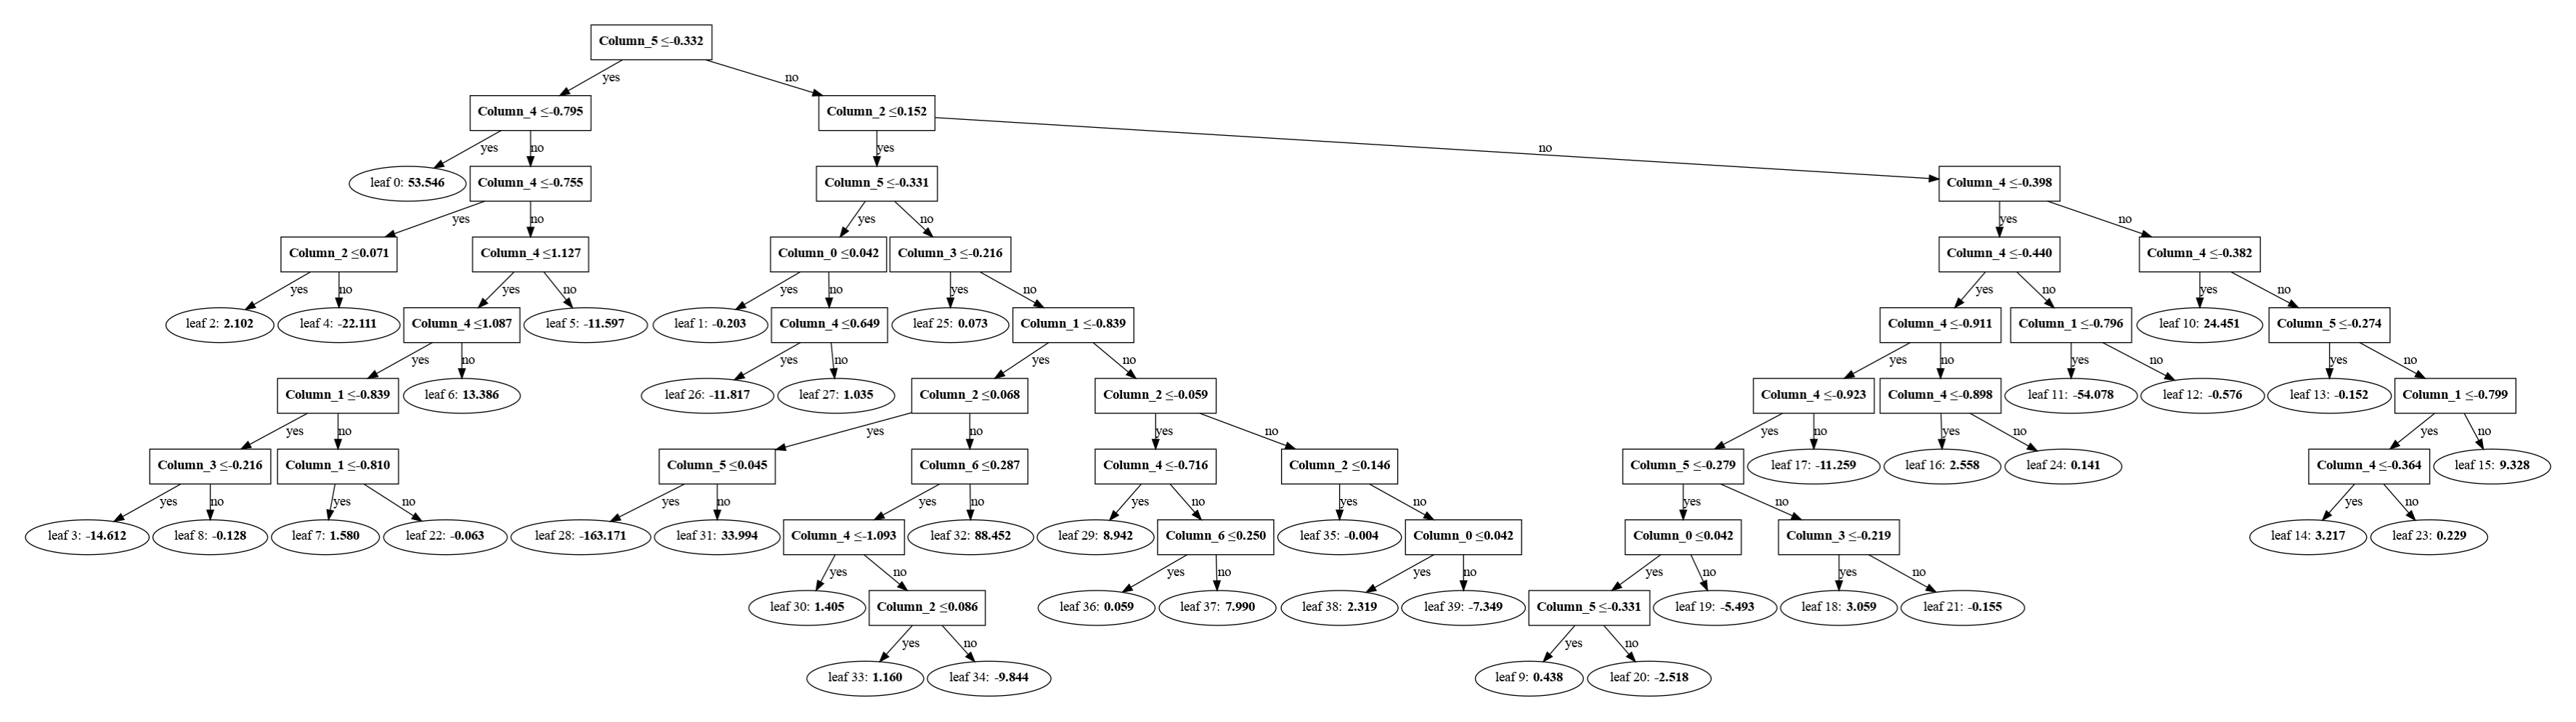

In [73]:
# and each estimator is a decision tree (basically a step function)
lightgbm.plot_tree(model.estimator[1]._Booster, tree_index=42, orientation='vertical', dpi=300, figsize=(15,25))

### How is the model behaving

In [74]:
from lime import lime_tabular
model.features

['BKB-31ECCCEC726744898554A981A0D7D901',
 'BKB-56D51F621558447A80A58A8CF875654C',
 'BKB-7386107D608B45D7A1AAF3EE6C280919',
 'BKB-62F49FF0F63F46C99A5610E5A09B95E6',
 'BKB-9CB76C671FCE4A33B5542CDE7FC79BF9',
 'BKB-BCC667058C084D32983E5934FB787A3D',
 'BKB-E966B4307D274777B4000A3E11BC0373']

In [75]:
# instantiate an explainer
explainer = lime_tabular.LimeTabularExplainer(df_j[features].values, mode="regression", 
                                              feature_names=features,verbose=True)
explainer

In [76]:
# to understand why the model is predicting 163.81327313 
# for input feature vector 302.480469, 55.8369141, 21.8830566, 38.1333
# the explainer evaluate the result of calling model.predict for some values around this single features 
#   (around = normally distributed around it)
# then it applies a simple linear model and uses the coefficients to interpret feature importance locally
X = df_j[features].values[42]
("feature vector: ", X, "target: ", model.estimator.predict(X.reshape(1,-1)))



X does not have valid feature names, but StandardScaler was fitted with feature names


('feature vector: ',
 array([ 435.8516 ,  306.4883 ,  400.582  ,   34.64355,   80.87207,
          73.61621, 1357.219  ]),
 'target: ',
 array([146.20697802]))

In [77]:
explanation = explainer.explain_instance(X, model.estimator.predict, num_features=len(features))

Intercept -795.9168758643928
Prediction_local [452.36852533]
Right: 146.2069780184734


X does not have valid feature names, but StandardScaler was fitted with feature names


In [78]:
# coefficients of the surrogate linear rigde regression model
explanation.as_list()

[('304.98 < BKB-56D51F621558447A80A58A8CF875654C <= 315.60',
  644.9809575769981),
 ('72.52 < BKB-BCC667058C084D32983E5934FB787A3D <= 74.45', 527.4870187635767),
 ('BKB-9CB76C671FCE4A33B5542CDE7FC79BF9 > 75.17', 209.80257359930505),
 ('33.87 < BKB-62F49FF0F63F46C99A5610E5A09B95E6 <= 35.04',
  -114.54839200384667),
 ('BKB-31ECCCEC726744898554A981A0D7D901 > 435.20', 68.21987924095782),
 ('392.96 < BKB-7386107D608B45D7A1AAF3EE6C280919 <= 400.66',
  -61.481656837950986),
 ('1344.97 < BKB-E966B4307D274777B4000A3E11BC0373 <= 1509.38',
  -26.174979142908377)]

In [79]:
# same coefficients beautified
explanation.show_in_notebook()